In [19]:
import pandas as pd
from nltk.stem import PorterStemmer
import string
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk import sent_tokenize
from nltk.corpus import movie_reviews
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

# Esercizio 1.3 - WSI e pseudo-word evaluation
Implementazione di un sistema di _Word Sense Induction_ che utilizza il metodo della _pseudo-word evaluation_ per disambiguare due termini.

Per questo esercizio è stato utilizzato il corpus _movie reviews_ di NLTK, contenente recensioni di film.

In [20]:
# import nltk
# nltk.download("movie_reviews")

Definiamo una funzione di preprocessing ed una funzione per estrarre il contesto dalle frasi.
Il contesto viene estratto prendendo le 4 parole a dx e le 4 parole a sx della parola target.

In [21]:
# Loading stopwords list from file
stopwords = []
for line in open("utils/stop_words_FULL.txt", 'r').readlines():
    stopwords.append(line.rstrip('\n'))

# Initializing nltk.PorterStemmer()
ps = PorterStemmer()

def preprocessing(s):
    """
    Do some preprocessing operations on the string.

    :param s: the string

    :return: the preprocessed string
    """
    # Lowercasing
    s = s.lower()
    # Punct removal
    s = s.translate(str.maketrans('', '', string.punctuation))
    # Stopword removal
    s = ' '.join([word for word in s.split() if word not in stopwords])
    # Stemming
    s = ' '.join([ps.stem(word) for word in s.split()])
    return s


def get_context(w, s):
    """
    Retrieve the context from a sentence, given the word w it takes the 4 words at its left and the 4 words at its right.

    :param w: the target word
    :param s: the sentence containing the word

    :return: the context of the words
    """
    s = s.split()
    return s[s.index(w)-4:s.index(w)+5]

In [22]:
def get_sentences(word, corpus):
    """
    Given a corpus and a word, return all the senteneces with that word.

    :param word: the word that must be contained in the sentences
    :param corpus: the corpus in which the search must be done

    :return: the list of sentences containing the word
    """
    i = 0
    sentences = []
    while True:
        try:
            review = corpus.raw(corpus.fileids()[i])
            if word in review.split():
                for s in sent_tokenize(review): # le recensioni contengono più frasi, le dividiamo considerandole singolarmente
                    if word in s.split():
                        sentences.append(s)
            i += 1
        except IndexError:
            break
    return sentences

### Creazione dei cluster di riferimento
Scegliamo due parole $w_1, w_2$ con cui estrarremo le frasi dal corpus.

In [23]:
w1 = 'school'
w2 = 'car'

sentences = get_sentences(w1, movie_reviews)
sentences += get_sentences(w2, movie_reviews)
sentences = list(set(sentences)) # rimuoviamo le frasi duplicate
df = pd.DataFrame(data=sentences, columns=['sentences'])
print(f'\nNumero totale di frasi estratte:', len(df))
print(df.head())

# salviamo le frasi ed i loro indici, in modo da poter modificare la frase conservando però un riferimento alla versione originale
indexes_w1 = []
sentences_w1 = []
indexes_w2 = []
sentences_w2 = []
i = 0
for line in df['sentences']:
    if w1 in line.split():
        indexes_w1.append(i)
        sentences_w1.append(line)
    elif w2 in line.split():
        indexes_w2.append(i)
        sentences_w2.append(line)
    i += 1

df_w1 = pd.DataFrame(data=sentences_w1, index=indexes_w1, columns=['sentences w1'])
df_w2 = pd.DataFrame(data=sentences_w2, index=indexes_w2, columns=['sentences w2'])

# stampiamo il numero di frasi trovate e le prime 5 della lista
print(f'\nNumero di frasi con \'{w1}\':', len(df_w1))
print(df_w1.head())

print(f'\nNumero di frasi con \'{w2}\':', len(df_w2))
print(df_w2.head())


Numero totale di frasi estratte: 652
                                           sentences
0  angela bassett displays her usual forceful sta...
1  although libby never leaps from a bus that col...
2  a prime example of this is 1999's 10 things i ...
3  consider for a moment what a television produc...
4  then , after cage gets his gun , gandolfini th...

Numero di frasi con 'school': 359
                                        sentences w1
0  angela bassett displays her usual forceful sta...
2  a prime example of this is 1999's 10 things i ...
3  consider for a moment what a television produc...
5  truth be told , all three of the leads look to...
6  tingle , but was changed after the columbine h...

Numero di frasi con 'car': 293
                                        sentences w2
1  although libby never leaps from a bus that col...
4  then , after cage gets his gun , gandolfini th...
7  after turning them down , jan changes his mind...
8  everett scott ( jonathan adams , who played 

### Pseudo-word evaluation
Applichiamo ora il metodo della __pseudo-word evaluation__.
Sostituiamo all'interno del corpus ogni occorrenza delle due parole scelte con la loro concatenazione.

In [24]:
# concateniamo le due parole
w = w1 + w2
print(w1, '+', w2,'=', w)

# ogni volta che una delle due parole viene trovata, si procede a sostituirla con la concatenazione per poi processare la frase
sentences_w = []
indexes_w = []
i = 0
for line in df['sentences']:
    line = preprocessing(line)
    if w1 in line.split() or w2 in line.split():
        line = re.sub('|'.join("((?<=\s)|(?<=^)){}((?=\s)|(?=$))".format(i) for i in [w1, w2]), w, line) # sostituzione con la concatenazione
        try:
            line = get_context(ps.stem(w), line)
            line.remove(ps.stem(w))
            line = ' '.join(word for word in line)
            indexes_w.append(i)
            sentences_w.append(line)
        except ValueError as ve:
            # a volte il contesto non riesce a prendere tutte le parole (ad es. se la parola è alla fine della frase non riesce a prendere la parte di contesto alla sua dx). In questo caso si salta la frase, avremo quindi un numero di frasi minore
            pass
    i += 1

df_w = pd.DataFrame(data=sentences_w, index=indexes_w, columns=['sentences w1+w2'])
print(f'\nNumero di frasi con \'{w}\':', len(df_w))
print(df_w.head())

school + car = schoolcar

Numero di frasi con 'schoolcar': 475
                                     sentences w1+w2
0  william princip inner citi initi doesnt hire r...
1     chase beach jeep chain plung ocean seal coffin
2                              basic tame shrew high
3      produc book featur fatal bu accid lawyer sign
4                         gandolfini decid best side


Sulle frasi contenenti la pseudoword procediamo con il clustering. Questo meccanismo serve ad indurre i sensi partendo dalle frasi: ogni cluster estratto corrisponderà ad un senso delle parole.

/home/pietro/Scrivania/python venv/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


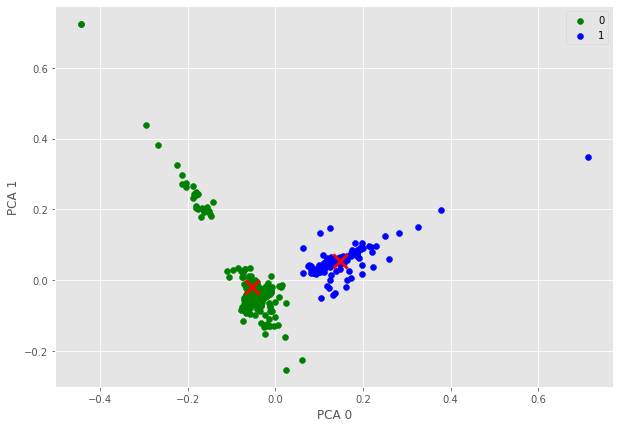

                                     sentences w1+w2  cluster
0  william princip inner citi initi doesnt hire r...        0
1     chase beach jeep chain plung ocean seal coffin        0
2                              basic tame shrew high        1
3      produc book featur fatal bu accid lawyer sign        0
4                         gandolfini decid best side        0


In [25]:
def plot_clusters(model, X):
    # prendiamo i clusters
    clusters = model.predict(X)

    # usiamo la PCA per avere una versione densa della matrice (il TFIDF crea una matrice sparsa)
    pca = PCA(n_components=2)
    two_dim = pca.fit_transform(X.todense())

    scatter_x = two_dim[:, 0] # prima componente principale
    scatter_y = two_dim[:, 1] # seconda componente principale
    plt.style.use('ggplot')
    fig, ax = plt.subplots()
    fig.set_size_inches(10,7)

    # color map per i clusters
    cmap = {0: 'green', 1: 'blue', 2: 'red'}

    # raggruppiamo per ogni cluster e costruiamo il grafico
    for group in np.unique(clusters):
        ix = np.where(clusters == group)
        ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group)
    ax.legend()
    plt.xlabel("PCA 0")
    plt.ylabel("PCA 1")

    # inseriamo i centroidi
    centers2D = pca.transform(model.cluster_centers_)
    plt.scatter(centers2D[:,0], centers2D[:,1], marker='x', s=200, linewidths=3, c='r')
    plt.show()


def clustering_tf_idf2(sentences, n_clusters):
    """
    Clustering of sentences using Term Frequency-Inverse Document Frequency and K-means algorithm.

    :param sentences: list of sentences
    :param n_clusters: number of clusters

    :return: return cluster's labels for each one of the given sentences
    """
    # vettorizziamo il testo ottenendo features numeriche
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # clustering
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=1000, n_init=500, random_state=27)
    model.fit(X)

    # plot dei clusters
    plot_clusters(model, X)

    return model.labels_


labels_w = clustering_tf_idf2(df_w['sentences w1+w2'], 2) # vogliamo ottenere 2 sensi
df_w['cluster'] = labels_w

print(df_w.head())

Per valutare il sistema è sufficiente verificare le variazioni nei cluster. Verifichiamo quante delle frasi con la parola $w_1$ sono contenute in un cluster e quante frasi con la parola $w_2$ sono contenute nell'altro.

In [26]:
cluster0 = df_w[df_w['cluster'] == 0].index
cluster1 = df_w[df_w['cluster'] == 1].index

print('Elementi nel Cluster 0:  ', len(cluster0))
print('Elementi nel Cluster 1:  ', len(cluster1))

Elementi nel Cluster 0:   348
Elementi nel Cluster 1:   127


In [27]:
# contiamo gli elementi in comune fra gli indici delle frasi con la parola w1 (df_w1) e quelli del cluster trovato dall'algoritmo utilizzante la pseudoword
# confrontiamo gli indici delle frasi in modo da non avere problemi dovuti al preprocessing ed all'uso della pseudoword
intersection = len(df_w1.index.intersection(cluster1))
print(f'Il cluster 1 contiene {intersection}/{len(cluster1)} frasi contenti la pseudoword con il senso di \'{w1}\'.')


# contiamo gli elementi in comune fra gli indici delle frasi con la parola w2 (df_w2) e quelli del cluster trovato dall'algoritmo utilizzante la pseudoword
# confrontiamo gli indici delle frasi in modo da non avere problemi dovuti al preprocessing ed all'uso della pseudoword
intersection2 = len(df_w2.index.intersection(cluster0))
print(f'Il cluster 0 contiene {intersection2}/{len(cluster0)} frasi contenti la pseudoword con il senso di \'{w2}\'.')

Il cluster 1 contiene 125/127 frasi contenti la pseudoword con il senso di 'school'.
Il cluster 0 contiene 202/348 frasi contenti la pseudoword con il senso di 'car'.


Il sistema di WSI riesce ad indurre correttamente il senso della parola _school_, classificando correttamente quasi tutte le frasi e distinguendo le situazioni in cui la pseudoword è utilizzata con questo senso.
Per la parola _car_ incontra invece qualche difficoltà, riuscendo però comunque ad identificare correttamente il senso della pseudoword in più della metà delle frasi.